# Simple Classification example using TensorFlow

In this notebook, we use a simple data set to build a neural network used to classify it.

In particular, we will explore the concepts of:

- callbacks
- model metrics to assess its overall performances


## Import

## Machine learning framework

As usual, we build our Notbook following the classical machine learning framework

- Preapre the data
- choose or build a model
- train the model
- evaluate the model
- improvde the model
- save and load the model

### Preparing the model

So for this step, we could either load and analyse our data using EDA, perform feature engineering, etc.

But ...

this is an introduction to classification using TensorFlow so instead what we are going to do is to build a dummy data set and perfome the Machine learning workflow on that. Now a good part of this process is spent on data analysis (EDA) but this can be a subject on its own and independant from the use of TensorFlow.

In [1]:
# Import of required modules:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.17.0


In [2]:
# let's prepare our data for this example: use of sklearn to grap a set of data !
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, noise= 0.04, random_state=42)

ok so now we have some data and we set a random seed in order to reproduce later on the results if we run the notebook severla time. In addition, we set a noise in order to bring a litte bit of variation in the data.

Let's investigate a bot those data !

In [3]:
# investigation of the data
X.shape, y.shape, X.ndim, y.ndim

((1000, 2), (1000,), 2, 1)

In [4]:
X[:5], y[:5]

(array([[ 0.74822656,  0.23908325],
        [-0.74509559,  0.16097526],
        [-0.82262532,  0.19762051],
        [-0.41143316,  0.68255648],
        [ 0.44390494, -0.89582949]]),
 array([1, 1, 1, 1, 0]))

ok so it seems that we have a binary array (y) and a second array with 1000 coupled values.

So from this points there are several ways we can improve our understanding of the data. Here since we are dealing with a toy data set we are going to visualize it graphically

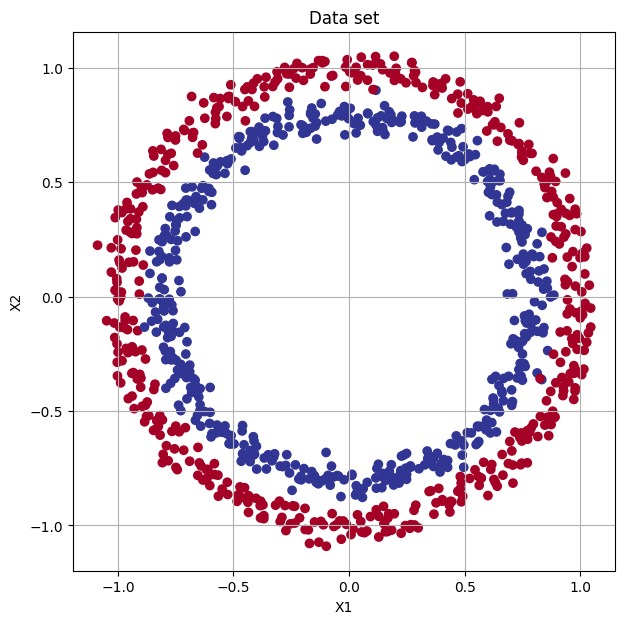

In [5]:
# Representation fo the dataset
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('Data set')
plt.grid()
plt.show()

When having a look at the data we can say that it draws two circles (on inside the other). The scattering of the data points is introduced thanks to the `noise`parameter. If set to `0`we would have ended with two perfect circles.

The object of the model will be to determine the two regions thanks to Deep learning and TensorFlow.

But first we need to split the data into several sets:

- training set
- validation set
- test set

we will limit to a training and test set since we do not have much data to work with.

In [6]:
# splitting into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

ok so now we have prepared our data and we can build our first model that we will evaluate and improve depending on the performance metrics !

### Choose or build a model

In this section, we will build a model from scratch.

In order to build a relevant model first, we need to take a look at our data. Indeed, we can see that we tray to classify or detect cricles, i.e., non-linear functions. It means that we need to introduce non-linearities within our neural network. Those non-linearities are introduced via activation functions. So when building our layers we need to set activation functions (except for the input layer which is really there to introduce the input in the model).

So let's get started !

In [7]:
# Before starting the model: check the shape of the input (only one)
X.shape, X[0].shape


((1000, 2), (2,))

In [8]:
tf.random.set_seed(42)
#1. Build the model
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),  # set here the shape of one input !!!!
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

#2. Compile the model
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

Ok so just a side note here:
we use two different activation function for the hidden layer and the output layer. For the output layer, we use a sigmoid since this function by essence will push the output values towards one or zero (since we are in a binary classification that makes the most sense). As for Relu, it is quiet efficient to evalute hence is chosen for performance but also for some numerial stability.

### Train the model

In [9]:
#3. train the model
history = model1.fit(X_train, y_train, epochs=100, verbose=False)

### Evaluate the model

Ok in this section we are going to evaluate the model. First we will depict the history of the loss function and see its converge to a small value. Then we will evaluate the accuray metric and derive a plan to imporove our model.

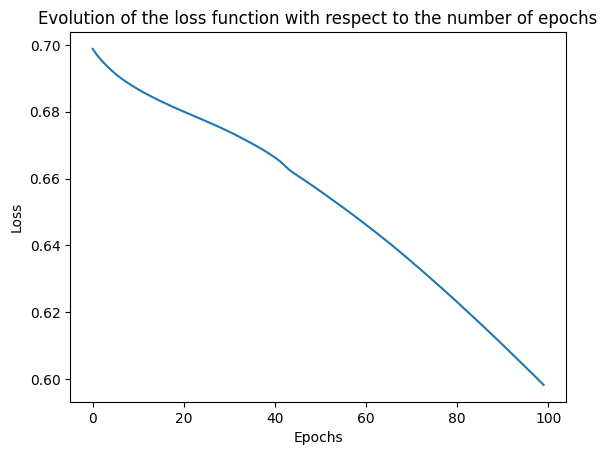

In [10]:
# Plot the history of the loss
plt.plot(history.history["loss"]);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evolution of the loss function with respect to the number of epochs")
plt.show()

In [11]:
# evaluate the model
loss1, acc1 = model1.evaluate(X_test,y_test)
print("Loss: ", loss1)
print(f"Accuracy:  {acc1*100:.2f}%" )

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7621 - loss: 0.6158  
Loss:  0.6204597353935242
Accuracy:  73.00%


It could be nice from here to visualy see what the model has predicted, i.e., separate the regions of red dot and blue dot. Since we are going to use this representation later to assess the improvement brought to our model, we can functionize this.

Now the idea is to "paint" the entire space where the algorithm detect a red or blue dot. So we need to use the contour method. In order to get all the points of the domain, we need to assign a value to each point hence we need a meshgrid.

In [12]:
# function to represent the classification of the algorithm
def plot_classification_region(X,y, model):
  """
  Function to plot the classification of the algorithm
  """
  # Setting our limits for our meshgrid
  x_min, x_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
  y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1
  # creating our meshgrid
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  # creating the input for the model (concatenation of flatten array from the meshgrid: get all the pairs of point !)
  X_plot = np.c_[xx.ravel(), yy.ravel()]

  #making predictions:
  # We get our predictions that need to be mapped onto the meshgrid so we need to reshape the result of our prediction accordingly.
  # In addtion we need to round the results in order to get 0-1 values !
  y_pred = model.predict(X_plot)
  y_pred = np.round(y_pred)


  #plotting the contours
  plt.contourf(xx,yy, y_pred.reshape(xx.shape), alpha=0.3, cmap=plt.cm.RdYlBu)

  #plotting the data points
  plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


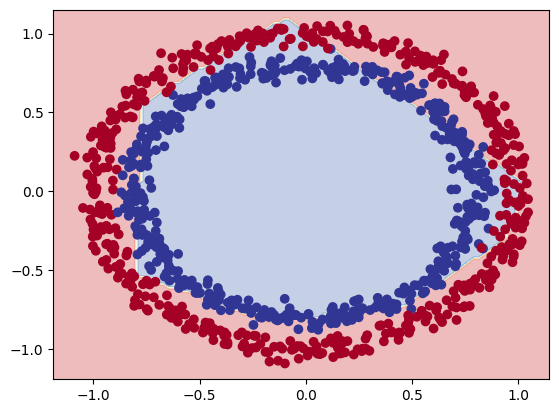

In [13]:
plot_classification_region(X, y, model1);


As we can see, it seems that the model started to draw the difference between the two regions. So we can conclude that maybe with more iterations, we would have ended at a better solution.

### Improve the model

Having a look at the first attempt above, it appears clearly that we need to let it run for more epochs since it apprears we did not reach convergence. So the first improvement will be as such.

Then, we will decide what to do in order to further refine our model

In [14]:
def plot_history(history):
  """
  function that plot the history of the loss function

  """
  # Plot the history of the loss
  plt.plot(history.history["loss"]);
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Evolution of the loss function with respect to the number of epochs")

In [15]:
# increase the number of epochs !
tf.random.set_seed(42)
#1. Create the model
model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

#2. Compile the model
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

#3. Fit the model
history2 = model2.fit(X_train, y_train, epochs=400, verbose=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


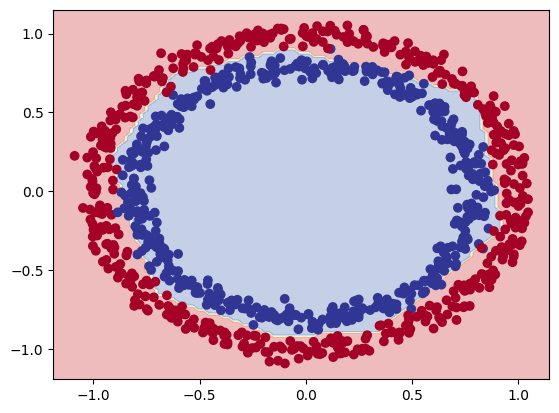

In [16]:
# lets plot the results here:
plot_classification_region(X, y, model2);

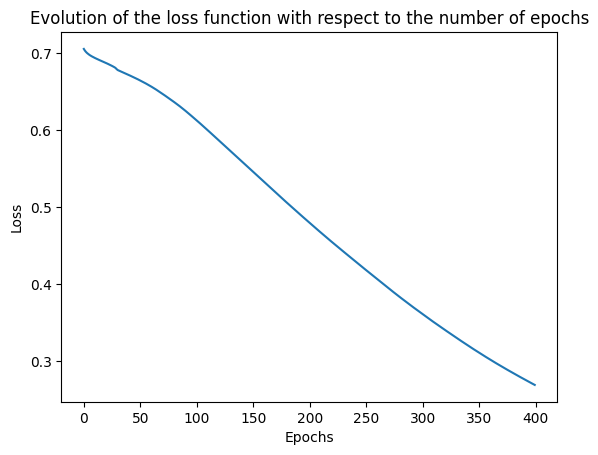

In [17]:
# Let's plot the evolution of the loss function with respect to the epochs !
plot_history(history2)

In [18]:
# evaluate:
loss2, acc2 = model2.evaluate(X_test,y_test)
print("Loss: ", loss2)
print(f"Accuracy:  {acc2*100:.2f}%" )

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9453 - loss: 0.3235  
Loss:  0.3419876992702484
Accuracy:  93.50%


it appears that we have a better results but we can improve further.

### Improving the model by adding extral layers

In here we will add some extra layers to the model in order to further improve the model

In [19]:
tf.random.set_seed(42)
# Let's add some layers to the model
#1. Build the model

model3 = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

#2. Compile the model
model3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

#3. Fit the model
history3 = model3.fit(X_train, y_train, epochs=400, verbose=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


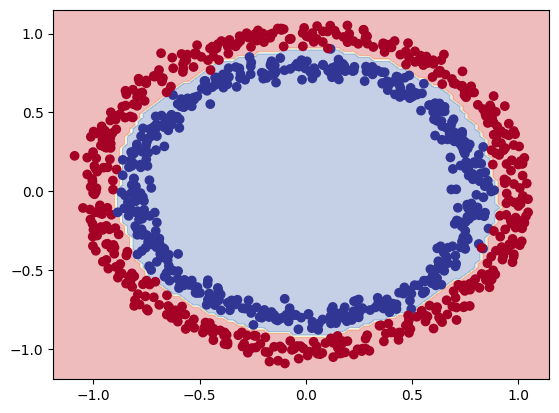

In [20]:
# Visualize the predictions
plot_classification_region(X, y, model3);

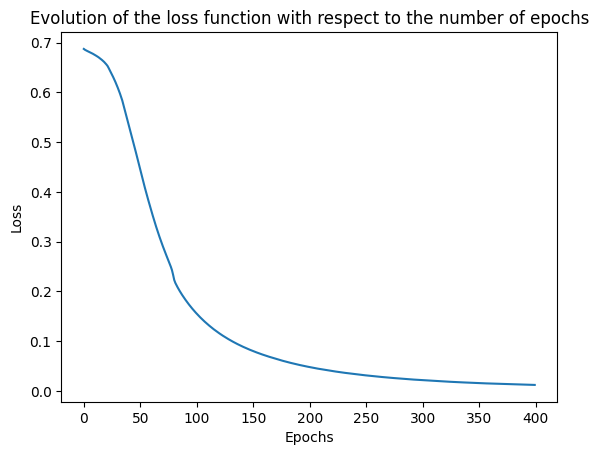

In [21]:
# Represent the history
plot_history(history3)

In [22]:
# Evaluate the model
loss3, acc3 = model3.evaluate(X_test, y_test)
print("Loss: ", loss3)
print(f"Accuracy:{acc3*100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9827 - loss: 0.0514  
Loss:  0.054417576640844345
Accuracy:98.00%


Adding additional complexity and non-linearity have improved even more the model and we can see that the loss curve tends to a stablization. Let's try another improvement by tweaking the learning rate of our optimizer.

### Improving the model by tweaking the learning rate

In [23]:
tf.random.set_seed(42)
#1. Build the model
model4 = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

#2. Compile the model
model4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=["accuracy"])
#3. Fit the model
history4 = model4.fit(X_train, y_train, epochs=400, verbose=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


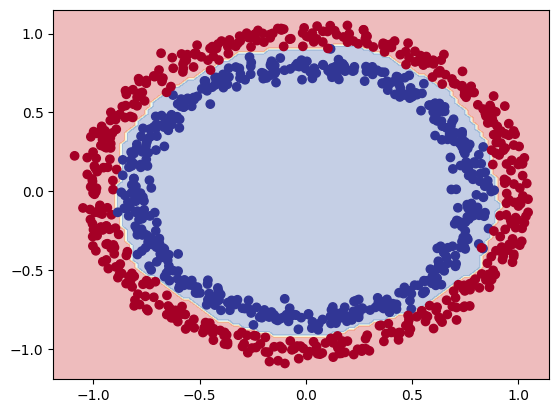

In [24]:
# Visualize the predictions
plot_classification_region(X, y, model4);

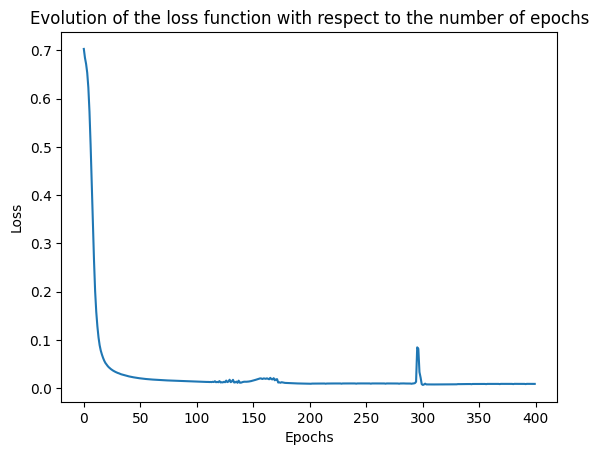

In [25]:
# plot the model loss history
plot_history(history4)

In [26]:
# Evaluate the model
loss4, acc4 = model4.evaluate(X_test, y_test)
print("Loss: ", loss4)
print(f"Accuracy: {acc4*100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0345  
Loss:  0.04190016910433769
Accuracy: 98.00%


Ok so it turns out that in this example, we did not achieve better results but still we manage to improve up to 98% of accuracy ! it means that out of 100 samples, only two are not well predicted.

In addition, we can see that using a learning rate allows to reach convergence in less epochs ! So why not launch the model again but for maybe 200 epochs. We will not do it here though.

### Other metrics to assess the model performances

- accuracy (we have been using it since the begining)
- confusion matrix
- f1
- recall
- precision
- ROC curve
- AUC

in the following ...


In [29]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc

In [30]:
def metrics_classification(y_true, y_pred):
  """
  Function to compute the metrics of a classification model
  """
  # Compute the metrics

  confusion = confusion_matrix(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  # Create a dictionary with the metrics
  metrics = {
      "confusion_matrix": confusion,
      "f1_score": f1,
      "precision": precision,
      "recall": recall,
      "fpr": fpr,
      "tpr": tpr,
      "thresholds": thresholds,
      "roc_auc": roc_auc
  }
  return metrics
y_pred_4 = np.round(model4.predict(X_test))
metrics = metrics_classification(y_test, y_pred_4)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [35]:
print("Confusion matrix: ", metrics["confusion_matrix"])
print("f1 score: ", round(metrics["f1_score"],2))
print("Precision: ", round(metrics["precision"],2))
print("Recall: ", round(metrics["recall"],2))
print("ROC_AUC: ", round(metrics["roc_auc"],2))

Confusion matrix:  [[97  3]
 [ 1 99]]
f1 score:  0.98
Precision:  0.97
Recall:  0.99
ROC_AUC:  0.98


Ok several things here:
- The confuction matrix is not really nice to look at
- The ROC_AUC can be represented using a plot visualization

That being said, we can see that the metrics of our model are quiet nice indicating that we have a good predicting model.

In the following we will display the confusion matrix in a more nicer form factor as well as the ROC AUC.

#### Pretty confusion matrix
to prettify our confusion matrix we will use `seaborn`

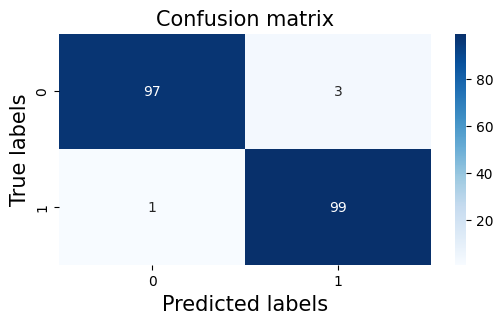

In [40]:
# using seaborn to plot our confusion matrix in a more graphical way
plt.figure(figsize=(6,3))
sns.heatmap(metrics["confusion_matrix"], annot=True, cmap='Blues', fmt="g")
plt.xlabel("Predicted labels", fontsize=15)
plt.ylabel("True labels", fontsize=15)
plt.title("Confusion matrix", fontsize=15)
plt.show()

#### ROC curve and Area Under the Curve (AUC)

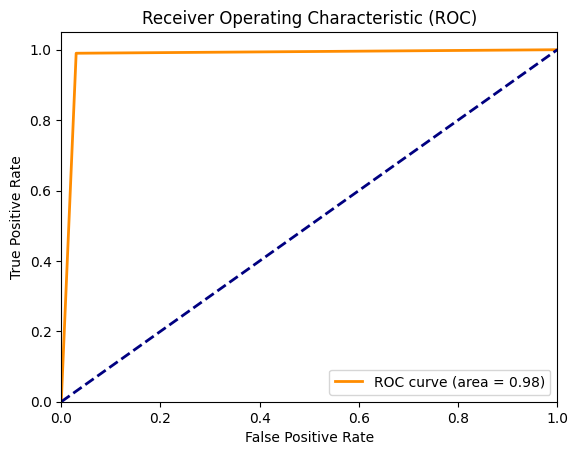

In [47]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area
fpr = metrics["fpr"]
tpr = metrics["tpr"]
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### save and load the model

In [49]:
model4.save("saved_model.keras")

In [27]:
# to load the model
# loded_model = tf.keras.load_model("saved_model.keras")